In [1]:
!git clone https://github.com/Jsrsky/machine_unlearning_experiments
%cd machine_unlearning_experiments/experiments/animal_faces/fisher

Cloning into 'machine_unlearning_experiments'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 268 (delta 9), reused 36 (delta 7), pack-reused 206 (from 1)
Receiving objects: 100% (268/268), 227.56 MiB | 39.53 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Updating files: 100% (70/70), done.
/kaggle/working/machine_unlearning_experiments/experiments/animal_faces/fisher


## Dependecies

In [2]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

## Utils 

In [3]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    
data_root = project_root / 'data'
data_root.mkdir(parents=True, exist_ok=True)

from notebook_setup import setup_notebook
setup_notebook()

Notebook setup completed. Project root added to sys.path: /kaggle/working/machine_unlearning_experiments


In [4]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed
set_seed()

from utils.utils import save_model

from models.effnetb0 import load_model_effnetb0, init_model_effnetb0

# Merics 
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import compute_fisher_matrix, fisher_unlearning, create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)

In [5]:
BATCH_SIZE = 32
MINI_BATCH_SIZE = BATCH_SIZE

SIGMA = 1.0

# CALL FISHER

### Files

In [6]:
model_file = project_root / 'experiments/animal_faces/naive/EffNetB0_AFHQ_model.pth'
samples_to_unlearn_file = project_root / 'experiments/animal_faces/naive/afhq_samples_to_unlearn.json'
remaining_dataset_file = project_root / 'experiments/animal_faces/naive/updated_afhq_data_splits.json'

### Init models

In [7]:
original_model, original_model_name, criterion, _optimizer, transform = load_model_effnetb0(model_pth_path=model_file)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = 'fisher_' + original_model_name

Load model...
Init model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


Done initializing model.
Model ID: 133304977547152, Optimizer ID: 133304977547440, Criterion ID: 133304977547392
Done loading model.


## Init data

In [8]:
data_root = Path('/kaggle/input/animal-faces')

In [9]:
train_dataset = datasets.ImageFolder(root=data_root/'afhq/train', transform=transform)
test_dataset = datasets.ImageFolder(root=data_root/'afhq/val', transform=transform)

In [10]:
train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
    data_splits_file=remaining_dataset_file,
    datasets=(train_dataset, test_dataset), 
    batch_size=BATCH_SIZE)

unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

Recreating DataLoaders...
Done recreating DataLoaders.


### FIM

In [11]:
fim = compute_fisher_matrix(model_to_unlearn, train_loader, criterion)

Calculating FIM...: 100%|██████████| 329/329 [01:55<00:00,  2.84it/s]


### Unlearn

In [12]:
unlearned_model = fisher_unlearning(model_to_unlearn, unlearn_loader, fim, criterion, sigma=SIGMA)

Unlearning Process...: 100%|██████████| 46/46 [00:20<00:00,  2.23it/s]


In [13]:
save_model(unlearned_model, f'{model_to_unlearn_name}_model.pth')

### Test and metrics

In [14]:
model, *_ = init_model_effnetb0()
model_path = f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader)

Init model...
Done initializing model.
Model ID: 133304971000512, Optimizer ID: 133304970988080, Criterion ID: 133304970988416
Loading and testing model: fisher_EffNetB0_AFHQ


Evaluating model: fisher_EffNetB0_AFHQ_model.pth: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]

Predictions and labels saved to fisher_EffNetB0_AFHQ_predictions.json


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Metrics for fisher_EffNetB0_AFHQ:
  - Test Accuracy: 0.3333
  - Precision: 0.1111
  - Recall: 0.3333
  - F1 Score: 0.1667


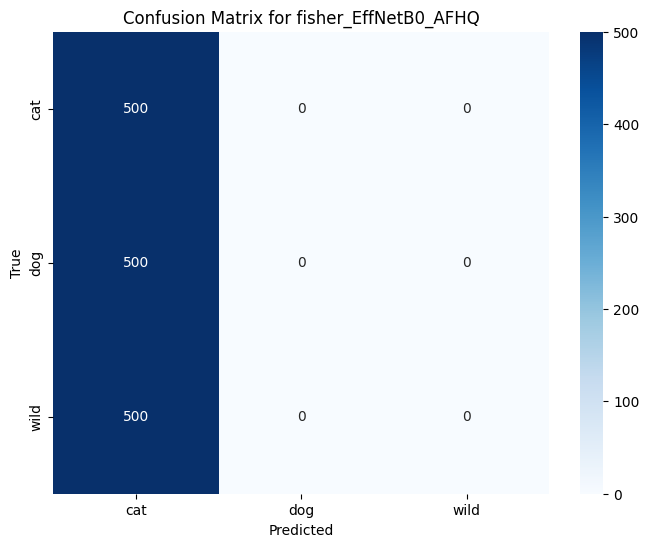

In [15]:
predictions_path = f'{model_to_unlearn_name}_predictions.json'
# classes = ['cat', 'dog', 'wildlife']
show_metrics(predictions_path, classes, model_to_unlearn_name)